In [32]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [33]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
from quetzal.io import excel
import pandas as pd
if manual:
    %matplotlib inline

In [34]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [35]:
distribution = stepmodel.read_zip(training_folder + r'model/{scen}/distribution.zip'.format(scen=scenario))
pt = stepmodel.read_zip(training_folder + r'model/{scen}/pruning_pt_pathfinder.zip'.format(scen=scenario))
car = stepmodel.read_zip(training_folder + r'model/{scen}/aon_pathfinder.zip'.format(scen=scenario))

read_hdf: 100%|████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 19.26it/s]


In [36]:
sm = pt.copy()
sm.car_los = car.car_los
sm.volumes = distribution.volumes
# each segment will be processed independently in the logit
sm.segments = ['car_owner', 'pt_captive'] 

In [37]:
# the scenario specific variables are read from the parameter file
var = excel.read_var(file='../../inputs/parameters.xlsx', scenario=scenario)
var.head()

category               parameter        
general                parent               base
                       bus_speed_factor      0.8
                       boarding_cost_acf     300
                       boarding_cost_wor     300
preparation_footpaths  max_length           3000
Name: base, dtype: object

In [38]:
kwargs = var['preparation_logit'].to_dict()
kwargs

{'time': -0.00055,
 'price': -1,
 'transfers': -0.25,
 'mode': 1,
 'pt_mode': 0.5,
 'pt_path': 0.1}

# LOGIT SCALES

In [39]:
sm.preparation_logit(
    segments=['car_owner', 'pt_captive'],
    **kwargs
)

In [40]:
sm.utility_values.T

value,time,price,ntransfers,mode_utility
segment,,,,
root,-0.00055,-1.0,-0.25,1.0
car_owner,-0.00055,-1.0,-0.25,1.0
pt_captive,-0.00055,-1.0,-0.25,1.0


In [41]:
sm.logit_scales.T # phi

route_type,rail,tram,subway,root,car,bus,walk,pt
segment,,,,,,,,
root,0.1,0.1,0.1,1.0,0.01,0.1,0.01,0.5
car_owner,0.1,0.1,0.1,1.0,0.01,0.1,0.01,0.5
pt_captive,0.1,0.1,0.1,1.0,0.01,0.1,0.01,0.5


In [42]:
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100 # PT captive can not use the car
sm.mode_utility.T

route_type,rail,tram,subway,root,car,bus,walk
segment,,,,,,,
root,0,0,0,0,0,0,0
car_owner,0,0,0,0,0,0,0
pt_captive,0,0,0,0,-100,0,0


In [43]:
sm.mode_nests.T # nested structure can be set for each segment

route_type,rail,tram,subway,root,car,bus,walk,pt
segment,,,,,,,,
root,pt,pt,pt,NaN,root,pt,root,root
car_owner,pt,pt,pt,NaN,root,pt,root,root
pt_captive,pt,pt,pt,NaN,root,pt,root,root


# UTILITY EVALUATION
## add relevant columns to path dataframes

In [44]:
sm.pt_los['ntransfers'] = sm.pt_los['alighting_links'].apply(lambda x: max(len(x)-1, 0))
sm.pt_los['price'] = 0 # sm.analysis_pt_fare
sm.car_los['ntransfers'] = 0
sm.car_los['price'] = 0

## calculate utility

In [45]:
# builds 'time' in pt_los based on the paths
sm.analysis_pt_time() 

# builds 'route_type' in pt_los based on 'route_types'
sm.analysis_pt_route_type(hierarchy=[ 'car','rail', 'subway', 'tram', 'bus', 'walk'])
sm.analysis_car_route_type() # add route_type = 'car' in car_los

# concatenate pt_los and car_los
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['path'] = sm.los['path'].apply(lambda p: tuple(p))

# add segment specific mode utility column
sm.analysis_mode_utility()

car_owner
pt_captive


In [46]:
sm.pt_los.head()

,alighting_links,alightings,all_walk,boarding_links,boardings,broken_modes,broken_route,destination,footpaths,gtime,...,ntransfers,price,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_types,route_type
0,[],[],True,[],[],"{bus, subway, rail, tram}",NaN,zone_73,[],0.000000e+00,...,0,0,0.000000,0.000000,0.0,0.0,0,0.000000,(),walk
1,[],[],True,[],[],"{bus, subway, rail, tram}",NaN,zone_75,[],2.000001e+09,...,0,0,795.590802,0.000000,0.0,0.0,0,795.590802,(),walk
2,[],[],True,[],[],"{bus, subway, rail, tram}",NaN,zone_71,[],2.000001e+09,...,0,0,883.601961,0.000000,0.0,0.0,0,883.601961,(),walk
3,[],[],True,[],[],"{bus, subway, rail, tram}",NaN,zone_77,[],2.000001e+09,...,0,0,1271.299408,0.000000,0.0,0.0,0,1271.299408,(),walk
4,[],[],True,[],[],"{bus, subway, rail, tram}",NaN,zone_70,"[(104, 210)]",2.000002e+09,...,0,0,863.323516,1018.576689,0.0,0.0,0,1881.900205,(),walk


## calulate the utilities and the probabilities

In [47]:
sm.initialize_logit()
sm.step_logit(verbose=True)

car_owner
path utilities bus 0.1 -> bus
path utilities car 0.01 -> car
path utilities rail 0.1 -> rail
path utilities subway 0.1 -> subway
path utilities tram 0.1 -> tram
path utilities walk 0.01 -> walk
mode utilities ['rail', 'tram', 'subway', 'bus'] 0.5 -> pt
mode utilities ['car', 'walk', 'pt'] 1.0 -> root
mode probabilities root 1.0 -> ['car', 'walk', 'pt']
mode probabilities pt 0.5 -> ['rail', 'tram', 'subway', 'bus']
path probabilities bus 0.1 -> bus
path probabilities car 0.01 -> car
path probabilities rail 0.1 -> rail
path probabilities subway 0.1 -> subway
path probabilities tram 0.1 -> tram
path probabilities walk 0.01 -> walk
pt_captive
path utilities bus 0.1 -> bus
path utilities car 0.01 -> car
path utilities rail 0.1 -> rail
path utilities subway 0.1 -> subway
path utilities tram 0.1 -> tram
path utilities walk 0.01 -> walk
mode utilities ['rail', 'tram', 'subway', 'bus'] 0.5 -> pt
mode utilities ['car', 'walk', 'pt'] 1.0 -> root
mode probabilities root 1.0 -> ['car', 'w

In [48]:
sm.od_probabilities.head()

(car_owner, root)  (car_owner, walk)  (car_owner, car)  \
zone_0 zone_0                  1           0.500000          0.500000   
       zone_1                  1           0.474883          0.525117   
       zone_2                  1           0.441944          0.558056   
       zone_3                  1           0.190700          0.411786   
       zone_4                  1           0.152475          0.426107   

               (car_owner, pt)  (car_owner, bus)  (car_owner, subway)  \
zone_0 zone_0         0.000000          0.000000             0.000000   
       zone_1         0.000000          0.000000             0.000000   
       zone_2         0.000000          0.000000             0.000000   
       zone_3         0.397513          0.224358             0.173155   
       zone_4         0.421418          0.191430             0.229987   

               (car_owner, tram)  (car_owner, rail)  (pt_captive, root)  \
zone_0 zone_0                0.0                0.0                   1   
       zone_1                0.0                0.0                   1   
       zone_2                0.0                0.0                   1   
       zone_3                0.0                0.0                   1   
       zone_4                0.0                0.0                   1   

               (pt_captive, walk)  (pt_captive, car)  (pt_captive, pt)  \
zone_0 zone_0            1.000000                0.0          0.000000   
       zone_1            1.000000                0.0          0.000000   
       zone_2            1.000000                0.0          0.000000   
       zone_3            0.324203                0.0          0.675797   
       zone_4            0.265685                0.0          0.734315   

               (pt_captive, bus)  (pt_captive, subway)  (pt_captive, tram)  \
zone_0 zone_0           0.000000              0.000000                 0.0   
       zone_1           0.000000              0.000000                 0.0   
       zone_2           0.000000              0.000000                 0.0   
       zone_3           0.381422              0.294375                 0.0   
       zone_4           0.333565              0.400750                 0.0   

               (pt_captive, rail)  
zone_0 zone_0                 0.0  
       zone_1                 0.0  
       zone_2                 0.0  
       zone_3                 0.0  
       zone_4                 0.0

In [49]:
sm.od_utilities.head() 

(car_owner, root)  (car_owner, walk)  (car_owner, car)  \
zone_0 zone_0           0.693147           0.000000          0.000000   
       zone_1           0.379985          -0.364701         -0.264150   
       zone_2           0.281639          -0.534932         -0.301658   
       zone_3           0.597465          -1.059586         -0.289786   
       zone_4           0.372349          -1.508406         -0.480714   

               (car_owner, pt)  (car_owner, bus)  (car_owner, subway)  \
zone_0 zone_0             -inf              -inf                 -inf   
       zone_1             -inf              -inf                 -inf   
       zone_2             -inf              -inf                 -inf   
       zone_3        -0.325061         -0.611055            -0.740581   
       zone_4        -0.491782         -0.886332            -0.794582   

               (car_owner, tram)  (car_owner, rail)  (pt_captive, root)  \
zone_0 zone_0               -inf               -inf            0.000000   
       zone_1               -inf               -inf           -0.364701   
       zone_2               -inf               -inf           -0.534932   
       zone_3               -inf               -inf            0.066801   
       zone_4               -inf               -inf           -0.182964   

               (pt_captive, walk)  (pt_captive, car)  (pt_captive, pt)  \
zone_0 zone_0            0.000000               -inf              -inf   
       zone_1           -0.364701               -inf              -inf   
       zone_2           -0.534932               -inf              -inf   
       zone_3           -1.059586               -inf         -0.325061   
       zone_4           -1.508406               -inf         -0.491782   

               (pt_captive, bus)  (pt_captive, subway)  (pt_captive, tram)  \
zone_0 zone_0               -inf                  -inf                -inf   
       zone_1               -inf                  -inf                -inf   
       zone_2               -inf                  -inf                -inf   
       zone_3          -0.611055             -0.740581                -inf   
       zone_4          -0.886332             -0.794582                -inf   

               (pt_captive, rail)  
zone_0 zone_0                -inf  
       zone_1                -inf  
       zone_2                -inf  
       zone_3                -inf  
       zone_4                -inf

In [50]:
sm.los.head(2) # utility and probability columns were added

,access_time,alighting_links,alightings,all_walk,boarding_links,boarding_time,boardings,broken_modes,broken_route,destination,...,route_type,route_types,time,time_link_path,transfers,waiting_time,"(car_owner, utility)","(pt_captive, utility)","(car_owner, probability)","(pt_captive, probability)"
0,0.000000,[],[],True,[],0.0,[],"{bus, subway, rail, tram}",NaN,zone_73,...,walk,(),0.000000,0.0,[],0.0,0.000000,0.000000,0.500000,1.0
1,795.590802,[],[],True,[],0.0,[],"{bus, subway, rail, tram}",NaN,zone_75,...,walk,(),795.590802,0.0,[],0.0,-0.437575,-0.437575,0.442085,1.0


# ASSIGNMENT

In [51]:
sm.pt_los = sm.los.copy()
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type'] != 'car']
sm.step_pt_assignment(
    volume_column=None,
    road=True,
    boardings=True,
    alightings=True,
    transfers=True,
)

pt_captive: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.80s/it]


In [52]:
sm.road_links

,index,a,b,length,geometry,car_owner,load,pt_captive
0,2,166297606,25240349,311.138,LINESTRING (262729.7945078692 6243769.07419266...,NaN,NaN,NaN
1,3,166297606,249076496,42.131,LINESTRING (262729.7945078692 6243769.07419266...,0.000000,0.000000,0.000000
2,4,271450120,27339859,96.693,LINESTRING (253573.7218623261 6253794.54536819...,2.406960,12.706970,12.706970
3,5,271450120,442306,103.415,LINESTRING (253573.7218623261 6253794.54536819...,NaN,NaN,NaN
4,8,166297610,166300778,64.116,LINESTRING (262785.899531229 6243675.806053707...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
15310,28198,185876056,25624514,218.029,LINESTRING (254667.0351092032 6251075.46160343...,NaN,NaN,NaN
15311,28199,25624242,25624516,183.818,LINESTRING (255130.9813509823 6251558.48137351...,45.576047,208.163585,208.163585
15312,28201,367584,21659622,63.438,LINESTRING (261102.2924205225 6247364.45836046...,60.530591,275.086721,275.086721
15313,28202,1142990067,21659622,317.402,LINESTRING (261665.9809260524 6247238.00186730...,43.040312,207.946633,207.946633


# XLSX EXPORT

In [53]:
sm.analysis_pt_length()
sm.analysis_pt_time()

sm.summary_link_max(inplace=True)
sm.summary_link_sum(inplace=True)
sm.summary_od(inplace=True)

sm.summary_path_average(inplace=True)
sm.summary_aggregated_path_average(inplace=True, pt_route_types=['subway', 'bus', 'tram', 'rail'])
sm.summary_path_sum(inplace=True)

s = sm.stack_link_sum.unstack([-1, -2]).groupby(level=0).sum().stack([0, 1])
s.name = 'sum'
sm.stack_aggregated_link_sum = s 
s = sm.stack_link_max.unstack().groupby(level=0).max().stack()
s.name = 'max'
sm.stack_aggregated_link_max = s

In [54]:
sm.od_los

segment                    car_owner                                    \
sum                           volume price        time in_vehicle_time   
origin  destination mode                                                 
zone_0  zone_0      car     0.000000   0.0    0.000000        0.000000   
                    walk    0.012453   0.0    0.000000        0.000000   
        zone_1      car     0.000000   0.0    0.000000        0.000000   
                    walk    0.072263   0.0  314.892046        0.000000   
        zone_10     bus     0.009173   0.0  239.769755       24.868124   
...                              ...   ...         ...             ...   
zone_99 zone_98     subway  0.118888   0.0  158.030985       53.746182   
                    tram    0.239064   0.0  281.649405       96.066549   
                    walk    0.129873   0.0  360.404133        0.000000   
        zone_99     car     0.000000   0.0    0.000000        0.000000   
                    walk    1.127965   0.0    0.000000        0.000000   

segment                                                 pt_captive        \
sum                        in_vehicle_length ntransfers     volume price   
origin  destination mode                                                   
zone_0  zone_0      car              0.00000    0.00000   0.000000   0.0   
                    walk             0.00000    0.00000   0.013790   0.0   
        zone_1      car              0.00000    0.00000   0.000000   0.0   
                    walk             0.00000    0.00000   0.252323   0.0   
        zone_10     bus            113.34953    0.00000   0.032051   0.0   
...                                      ...        ...        ...   ...   
zone_99 zone_98     subway           0.00000    0.09953   0.463141   0.0   
                    tram             0.00000    0.00000   0.931302   0.0   
                    walk             0.00000    0.00000   0.505935   0.0   
        zone_99     car              0.00000    0.00000   0.000000   0.0   
                    walk             0.00000    0.00000   1.740035   0.0   

segment                                                                   \
sum                               time in_vehicle_time in_vehicle_length   
origin  destination mode                                                   
zone_0  zone_0      car       0.000000        0.000000          0.000000   
                    walk      0.000000        0.000000          0.000000   
        zone_1      car       0.000000        0.000000          0.000000   
                    walk    663.093344        0.000000          0.000000   
        zone_10     bus     381.993623       39.619112        180.584902   
...                                ...             ...               ...   
zone_99 zone_98     subway  267.744036       91.059483          0.000000   
                    tram    477.184577      162.760775          0.000000   
                    walk    610.614794        0.000000          0.000000   
        zone_99     car       0.000000        0.000000          0.000000   
                    walk      0.000000        0.000000          0.000000   

segment                                    root                    \
sum                        ntransfers    volume price        time   
origin  destination mode                                            
zone_0  zone_0      car      0.000000  0.000000   0.0    0.000000   
                    walk     0.000000  0.026243   0.0    0.000000   
        zone_1      car      0.000000  0.000000   0.0    0.000000   
                    walk     0.000000  0.324586   0.0  585.573116   
        zone_10     bus      0.000000  0.041224   0.0  350.348128   
...                               ...       ...   ...         ...   
zone_99 zone_98     subway   0.168629  0.582029   0.0  245.333544   
                    tram     0.000000  1.170366   0.0  437.243663   
                    walk     0.000000  0.635809   0.0  559.505613   
     

In [55]:
stacks = {name[6:]: attr for name, attr in sm.__dict__.items() if name[:5] == 'stack'}
with pd.ExcelWriter(training_folder + r'model/%s/stacks.xlsx'%scenario) as writer:  
    for name, stack in stacks.items():
        stack.reset_index().to_excel(writer, sheet_name=name, index=False)

# GEOJSON EXPORT

In [56]:
if manual:
    sm.to_json(training_folder + 'json', omitted_attributes=['pt_los', 'car_los', 'los', 'od_los'])

to_hdf(overwriting):  76%|██████████████████████████████████████████████▋              | 39/51 [00:49<00:04,  2.46it/s]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes


to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 51/51 [00:50<00:00,  1.02it/s]


# ZIP EXPORT

In [57]:
sm.to_zip(training_folder + 'model/{scen}/logit.zip'.format(scen=scenario), omitted_attributes=['los'])

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.80it/s]


# PLOT

In [58]:
import numpy as np
paths = sm.pt_los
link_routes = sm.links['route_short_name'].to_dict()
def link_path_to_routes(link_path):
    routes = [link_routes[l] for l in link_path]
    used = set()
    rsn = []
    for route in routes:
        if route not in used:
            rsn.append(route)
        used.add(route)
    return rsn

paths['route_path'] = paths['link_path'].apply(link_path_to_routes)
paths['ntransfers'] = paths['transfers'].apply(len)

def title(paths):
    paths['min'] = np.round(paths['time'] / 60).astype(int)
    mins = (paths[['in_vehicle_time', 'access_time', 'footpath_time', 'waiting_time', 'time']] / 60).astype(int).astype(str)
    title = 'P = ' + (np.round(paths[('pt_captive', 'probability')], 2).fillna(0) * 100).astype(int).astype(str) + '%'
    title += ' | '+  paths['ntransfers'].astype(str) + ' transfers '
    title += ' | '+  paths['min'].astype(str) + ' mins | '
    title += paths['route_path'].apply(lambda l: '—>'.join(l) )
    title += '\n'+ 'in vehicle '+ mins['in_vehicle_time']+ "' | " + ' waiting '+ mins['waiting_time']+ "' | "  
    title += 'access ' + mins['access_time']+ "' | "   + ' footpaths '  + mins['footpath_time']+ "'"   
    return title


paths['title'] = title(paths)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.55s/it]


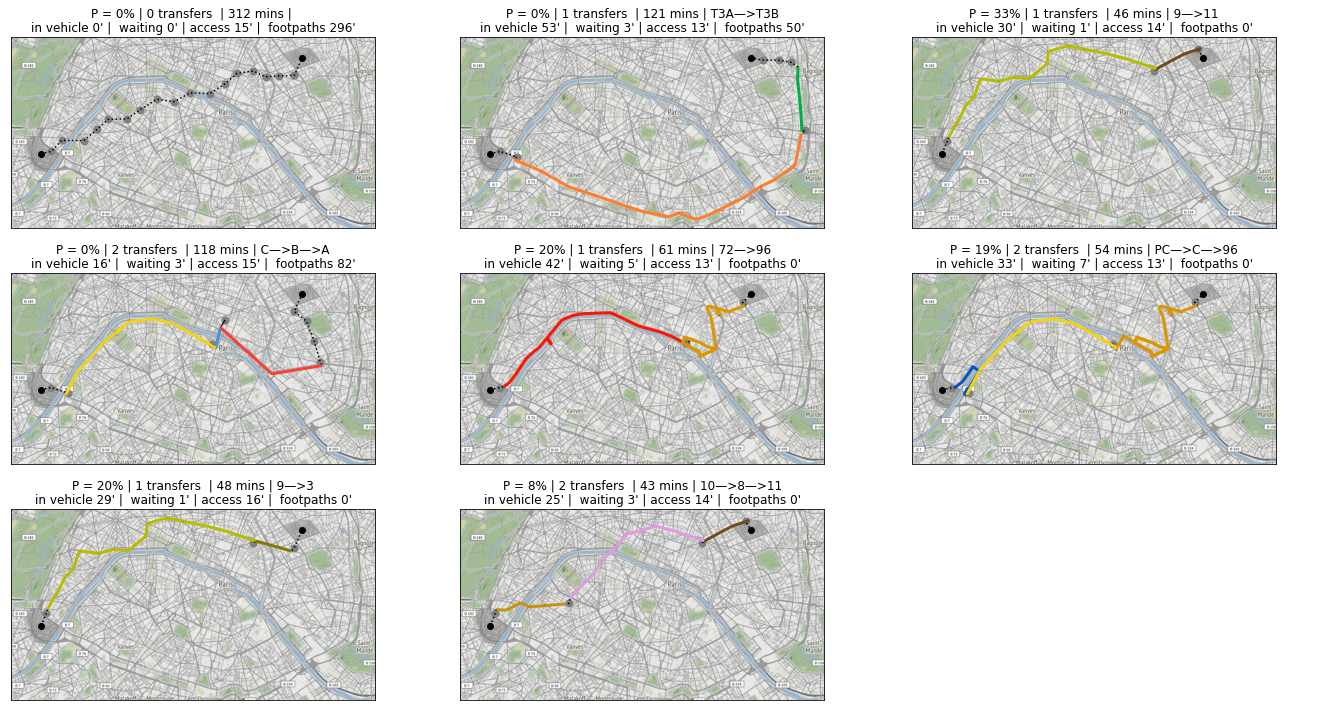

In [59]:
if manual:
    origin, destination='zone_74',  'zone_105'
    n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

    rows = 2
    if n > 6:
        rows = 3
    if n > 12:
        rows = 4

    columns = n // rows + bool(n%rows)


    url = 'http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'
    fig, axes = sm.plot_separated_paths(
        origin, destination, rows=rows, figsize=[20, 20],
        title='title', constrained_layout=True,
        basemap_url=url, zoom=13
    )
    ax = fig.get_axes()[0]
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
    fig.constrained_layout = True

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.48it/s]


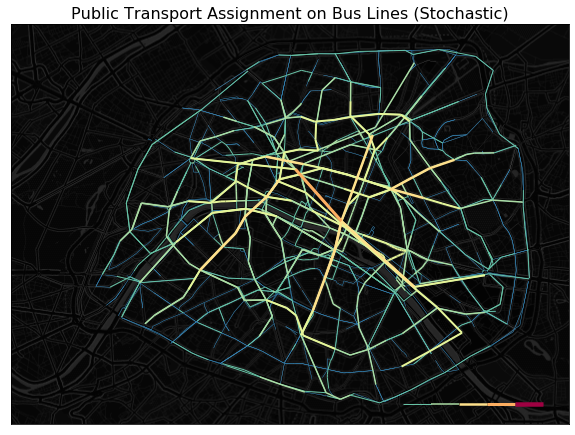

In [60]:
if manual:
    from syspy.syspy_utils import data_visualization as dv
    bandwidth = dv.bandwidth
    power=0.5
    lv = [100, 1000, 2000, 5000, 7000, 15000]
    url = 'http://a.basemaps.cartocdn.com/dark_nolabels/tileZ/tileX/tileY.png'

    i_links = sm.loaded_links.loc[sm.loaded_links.road_length.isnull()]
    df = pd.concat([i_links, sm.road_links])
    df['pt'] = df['pt_captive'] 
    df = df.loc[df['pt'] > 0]

    plot= bandwidth(
        df, value='pt', power=power, figsize=[10, 10], legend_values=lv, scale=0.5,
        label_kwargs={'color':'white', 'fontsize':14}
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title('Public Transport Assignment on Bus Lines (Stochastic)', fontsize=16)